## Data Science Demo
This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop. Please see the example README for instructions on how to prepare your environment for running this example.

Setup
Below we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

In [529]:
# Default address for accessing the RESTful API service
RESTAPI_ADDRESS = "http://localhost:80"

# Default address for accessing the MLFlow Tracking server
MLFLOW_TRACKING_URI = "http://localhost:35000"

---

# Set KEY experiment parameters

In [530]:
# KEY EXPERIMENT PARAMETERS
POLY_DEGREE = 7
SAMPLE_SIZE = 1000
ESTIMATOR_DEGREE = 1

In [531]:
EXPERIMENT_NAME = "Overfitting vs Underfitting"
EXPERIMENT_DESC = "Create a polynomial function then simulate data from it with gaussian noise, then fit linear estimator and measure MSE in and out of training subsets"
QUEUE_NAME = 'tensorflow_cpu'
QUEUE_DESC = 'Tensorflow CPU Queue'
PLUGIN_FILES = '../task-plugins/dioptra_custom/data_science_example/'

In [532]:
delete_past_jobs = False

In [533]:
# Import packages from the Python standard library
import importlib.util
import json
import os
import sys
import pprint
import time
import warnings
from IPython.display import display, clear_output
import logging
import structlog
from pathlib import Path

import time 
import matplotlib.pyplot as plt
from datetime import datetime

# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

def register_python_source_file(module_name: str, filepath: Path) -> None:
    """Import a source file directly.

    Args:
        module_name: The module name to associate with the imported source file.
        filepath: The path to the source file.

    Notes:
        Adapted from the following implementation in the Python documentation:
        https://docs.python.org/3/library/importlib.html#importing-a-source-file-directly
    """
    spec = importlib.util.spec_from_file_location(module_name, str(filepath))
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
register_python_source_file("scripts", Path("..", "scripts", "__init__.py"))

# Register the examples/scripts directory as a Python module
from scripts.utils import make_tar
from scripts.setup import upload_experiment, run_experiment, delete_all
from dioptra.client import connect_json_dioptra_client
# Set DIOPTRA_RESTAPI_URI variable if not defined, used to connect to RESTful API service
if os.getenv("DIOPTRA_API") is None:
    os.environ["DIOPTRA_API"] = RESTAPI_ADDRESS

# Set MLFLOW_TRACKING_URI variable, used to connect to MLFlow Tracking service
if os.getenv("MLFLOW_TRACKING_URI") is None:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI

print(f"The Dioptra Rest API Address is: {RESTAPI_ADDRESS}")
print(f"The MLFLOW Tracking URI is: {MLFLOW_TRACKING_URI}")

The Dioptra Rest API Address is: http://localhost:80
The MLFLOW Tracking URI is: http://localhost:35000


# Set up Client

In [534]:
client = connect_json_dioptra_client()
client

In [535]:
client.auth.login(
    username='dioptra-worker',
    password='Kjksa-Dbomaqqs-Uuiq-9'
)

{'username': 'dioptra-worker', 'status': 'Login successful'}

## Delete old jobs, experiments, entrypoints

In [536]:
# Delete Dioptra jobs
if delete_past_jobs:

    job_ids = client.jobs.get(page_length=100)['data']
    for job_id in job_ids:
        client.jobs.delete_by_id(job_id['id'])

### Delete MLFlow experiments (except experiment 0)

In [537]:
# Delete MLFlow experiments and runs
import mlflow
mlflow_client = mlflow.tracking.MlflowClient()

if delete_past_jobs:
    experiments = mlflow_client.search_experiments(view_type=3)
    if len(experiments)!=0:
        for experiment in experiments:
            exp_id = experiment.experiment_id
            run_ids = mlflow_client.search_runs(exp_id)
            for run_id in run_ids:
                r_id = run_ids[0].info.run_id
                mlflow_client.delete_run(r_id)
            if str(exp_id) != str(0):
                if experiment.lifecycle_stage == 'deleted':
                    mlflow_client.restore_experiment(exp_id)
                mlflow_client.rename_experiment(experiment_id=exp_id, new_name=f"Deleted on {datetime.now()}")
                mlflow_client.delete_experiment(exp_id)
                print(f"Deleted MLFLOW experiment {exp_id}")
            else:
                mlflow_client.rename_experiment(experiment_id=exp_id, new_name=EXPERIMENT_NAME)
                runs = mlflow_client.search_runs(exp_id)
                runs = mlflow_client.search_runs(exp_id)
                run_counter = 0
                for r in runs:
                    r_uuid = r.info.run_uuid
                    mlflow_client.delete_run(r_uuid)
                    run_counter +=1
                print(f"Deleted {run_counter} runs form default experiment {exp_id}")

            #run_ids    
            #mlflow_client.list_artifacts()

    active_experiments = mlflow_client.search_experiments(view_type=1)
    print(f"\nCurrently there is (are) {len(active_experiments)} active experiment(s)")
    if len(active_experiments)==0:
        exp_id = mlflow_client.create_experiment(EXPERIMENT_NAME)

print("\nCurrent MLFlow Experiments:")
mlflow_client.search_experiments(view_type=3)



Current MLFlow Experiments:


[<Experiment: artifact_location='s3://mlflow-tracking/artifacts/2', creation_time=1737129087721, experiment_id='2', last_update_time=1737133695096, lifecycle_stage='deleted', name='Deleted on 2025-01-17 12:08:15.054776', tags={}>,
 <Experiment: artifact_location='s3://mlflow-tracking/artifacts/1', creation_time=1737128848788, experiment_id='1', last_update_time=1737133695155, lifecycle_stage='deleted', name='Deleted on 2025-01-17 12:08:15.133612', tags={}>,
 <Experiment: artifact_location='s3://mlflow-tracking/artifacts/0', creation_time=1736963553439, experiment_id='0', last_update_time=1737133695178, lifecycle_stage='active', name='Overfitting vs Underfitting', tags={}>]

# Upload 2 entrypoints

In [538]:
experiment_id, gen_data_ep, queue_id = upload_experiment(client,
                                                    'src/generate_sim_data.yml',
                                                    'gen_data', 
                                                    f'Create polynomialdata points with gaussian noise',
                                                    PLUGIN_FILES,
                                                    QUEUE_NAME,
                                                    QUEUE_DESC,
                                                    EXPERIMENT_NAME,
                                                    EXPERIMENT_DESC)

experiment_id, fit_estimator_ep, queue_id = upload_experiment(client,
                                                    'src/fit_estimator.yml',
                                                    'fit_estimator',
                                                    'Fit a linear estimator and estimate MSE after splitting in trian/test/Out of Distribution',
                                                    PLUGIN_FILES,
                                                    QUEUE_NAME,
                                                    QUEUE_DESC,
                                                    EXPERIMENT_NAME,
                                                    EXPERIMENT_DESC)

print(f"""
Dioptra Experiment ID: {experiment_id}
Dioptra Entrypoint IDS: {gen_data_ep} for EP1 (simulation), {fit_estimator_ep} for EP2 (fitting estimator)
Dipotra Queue ID: {queue_id}
""")


Dioptra Experiment ID: 158
Dioptra Entrypoint IDS: 157 for EP1 (simulation), 159 for EP2 (fitting estimator)
Dipotra Queue ID: 9



# Submit Jobs 
- First job: generate polynomial and simulate datapoints
- Second job: Split dataset, train model, evaluate model

In [539]:
job_time_limit = '1h'


timestamp = datetime.now().strftime("%d/%m %H:%M")

gen_data_job =  client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"{timestamp} - Generating {SAMPLE_SIZE} data points of simulated data from polynomial of degree {POLY_DEGREE}", 
    queue_id=queue_id,
    entrypoint_id=gen_data_ep,
    values = {'poly_degree':str(POLY_DEGREE), 'sample_size':str(SAMPLE_SIZE)},
    timeout=job_time_limit
)

In [540]:
fit_estimator_job =  client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"{timestamp} - Fitting a Linear Estimator of degree {ESTIMATOR_DEGREE} and Gathering MSE Metrics", 
    queue_id=queue_id,
    entrypoint_id=fit_estimator_ep,
    values =  {'estimator_degree': str(ESTIMATOR_DEGREE), 
               'experiment_id':str(experiment_id), 'job_id': str(gen_data_job['id']) },
    #values = { 'job_id':str(gen_data_job['id'])},
    timeout=job_time_limit
)


# Retrieve Metrics

In [541]:
# Wait for job to finish
max_wait = 20; counter=0
job_finished = False
print(f"Waiting max of {max_wait} seconds for job to finish...")
while not job_finished:
    job_finished = client.jobs.get_by_id(fit_estimator_job['id'])['status'] == 'finished'
    if job_finished:
        print(f"Job {fit_estimator_job['id']} finished in {counter} seconds!")
    if  client.jobs.get_by_id(fit_estimator_job['id'])['status'] == 'failed':
        print(f"Job {fit_estimator_job['id']} failed after {counter} seconds")
        raise RuntimeError
    time.sleep(1)
    counter +=1
    if counter>max_wait:
        print("Maximum time elapsed waiting for job")
        raise TimeoutError

Waiting max of 20 seconds for job to finish...
Job 172 finished in 8 seconds!


In [542]:
# Retrieve Metrics
metrics = client.jobs.get_metrics_by_id(job_id=fit_estimator_job['id'])

# Visualize MSE Metrics

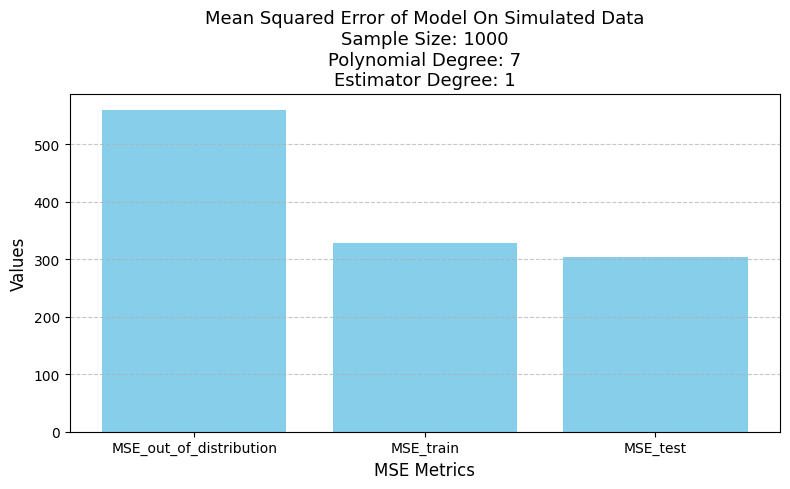

In [543]:
# Filter the relevant MSE values
mse_metrics = [metric for metric in metrics if metric['name'] in ['MSE_train', 'MSE_test', 'MSE_out_of_distribution']]
names = [metric['name'] for metric in mse_metrics]
values = [metric['value'] for metric in mse_metrics]

# Create the bar graph
plt.figure(figsize=(8, 5))
plt.bar(names, values, color='skyblue')
plt.title(f'Mean Squared Error of Model On Simulated Data\nSample Size: {SAMPLE_SIZE}\nPolynomial Degree: {POLY_DEGREE}\nEstimator Degree: {ESTIMATOR_DEGREE}', fontsize=13)

plt.xlabel('MSE Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
